# Twitter Sentiment & Stock Price

In [1]:
import pandas as pd
import numpy as np

# Load datasets
twitter_sentiment = pd.read_parquet('/kaggle/input/twitter-dataset/fin_sentiment.parquet')
stock_data = pd.read_json('/kaggle/input/twitter-dataset/S_P500.json')

# Format dates
twitter_sentiment['date'] = pd.to_datetime(twitter_sentiment['created_at']).dt.date

In [2]:
twitter_sentiment.head()

,id,created_at,text,pred_label,pred_score,date
0,1,2020-04-09 23:59:51+00:00,@KennyDegu very very little volume. With $10T ...,BULLISH,0.570444,2020-04-09
1,2,2020-04-09 23:58:55+00:00,#ES_F achieved Target 2780 closing above 50% #...,BULLISH,0.808406,2020-04-09
2,3,2020-04-09 23:58:52+00:00,RT @KimbleCharting: Silver/Gold indicator crea...,BULLISH,0.964979,2020-04-09
3,4,2020-04-09 23:58:27+00:00,@Issaquahfunds Hedged our $MSFT position into ...,BEARISH,0.935827,2020-04-09
4,5,2020-04-09 23:57:59+00:00,RT @zipillinois: 3 Surprisingly Controversial ...,BEARISH,0.927120,2020-04-09


In [3]:
stock_data.head()

,2020-04-09,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-20,2020-04-21,2020-04-22,2020-04-23,...,2020-07-02,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-13,2020-07-14,2020-07-15,2020-07-16
Adj Close_^GSPC,2789.820068,2761.629883,2846.060059,2783.360107,2799.550049,2874.560059,2823.159912,2736.560059,2799.310059,2797.800049,...,3130.010010,3179.719971,3145.320068,3169.939941,3152.050049,3185.040039,3155.219971,3197.520020,3226.560059,3215.570068
Close_^GSPC,2789.820068,2761.629883,2846.060059,2783.360107,2799.550049,2874.560059,2823.159912,2736.560059,2799.310059,2797.800049,...,3130.010010,3179.719971,3145.320068,3169.939941,3152.050049,3185.040039,3155.219971,3197.520020,3226.560059,3215.570068
High_^GSPC,2818.570068,2782.459961,2851.850098,2801.879883,2806.510010,2879.219971,2868.979980,2785.540039,2815.100098,2844.899902,...,3165.810059,3182.590088,3184.149902,3171.800049,3179.780029,3186.820068,3235.320068,3200.949951,3238.280029,3220.389893
Low_^GSPC,2762.360107,2721.169922,2805.100098,2761.540039,2764.320068,2830.879883,2820.429932,2727.100098,2775.949951,2794.260010,...,3124.520020,3155.290039,3142.929932,3136.530029,3115.699951,3136.219971,3149.429932,3127.659912,3200.760010,3198.590088
Open_^GSPC,2776.989990,2782.459961,2805.100098,2795.639893,2799.340088,2842.429932,2845.620117,2784.810059,2787.889893,2810.419922,...,3143.639893,3155.290039,3166.439941,3153.070068,3176.169922,3152.469971,3205.080078,3141.110107,3225.979980,3208.360107


In [4]:
# Group by date and count sentiment labels
daily_sentiment = (
    twitter_sentiment.groupby('date')['pred_label']
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={'BULLISH': 'pos', 'BEARISH': 'neg'})
)

In [6]:
daily_sentiment.head()

pred_label,neg,pos,NEUTRAL
date,,,
2020-04-09,5153,5664,3124
2020-04-10,2268,2432,1939
2020-04-11,1590,2017,1701
2020-04-12,1706,2216,2228
2020-04-13,3626,5374,3602


In [7]:
# Formula 1: Bullishness (ln of the ratio of positive to negative signals) [cite: 73]
daily_sentiment['bullishness'] = np.log((1 + daily_sentiment['pos']) / (1 + daily_sentiment['neg']))

# Formula 2: Message Volume (natural log of total sentiment tweets) [cite: 77, 79]
daily_sentiment['msg_volume'] = np.log(daily_sentiment['pos'] + daily_sentiment['neg'])

# Formula 3: Agreement (measure of consensus among investors) [cite: 80]
daily_sentiment['agreement'] = 1 - np.sqrt(1 - ((daily_sentiment['pos'] - daily_sentiment['neg']) / 
                                               (daily_sentiment['pos'] + daily_sentiment['neg']))**2)

In [20]:
daily_sentiment

pred_label,neg,pos,NEUTRAL,bullishness,msg_volume,agreement
date,,,,,,
2020-04-09,5153,5664,3124,0.094534,9.288874,0.001116
2020-04-10,2268,2432,1939,0.069786,8.455318,0.000609
2020-04-11,1590,2017,1701,0.237744,8.190632,0.007032
2020-04-12,1706,2216,2228,0.261417,8.274357,0.008491
2020-04-13,3626,5374,3602,0.393353,9.104980,0.019042
...,...,...,...,...,...,...
2020-07-12,1466,3646,2338,0.910685,8.539346,0.095488
2020-07-13,4550,9969,4547,0.784234,9.583213,0.072263
2020-07-14,4410,8324,4562,0.635162,9.452031,0.048409


In [21]:
# Transpose and fix index
stock_df = stock_data.T
stock_df.index = pd.to_datetime(stock_df.index)

# Rename columns based on paper requirements 
# Calculation 1: Log Returns 
stock_df['return'] = (np.log(stock_df['Close_^GSPC']) - np.log(stock_df['Close_^GSPC'].shift(1))) * 100

# Calculation 2: Log Trading Volume
stock_df['log_trading_vol'] = np.log(stock_df['Volume_^GSPC'])

# Calculation 3: Garman-Klass Volatility 
log_hl = np.log(stock_df['High_^GSPC'] / stock_df['Low_^GSPC'])**2
log_co = np.log(stock_df['Close_^GSPC'] / stock_df['Open_^GSPC'])**2
stock_df['volatility'] = np.sqrt(0.5 * log_hl - (2 * np.log(2) - 1) * log_co)

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
stock_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Adj Close_^GSPC,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,return,log_trading_vol,volatility
2020-04-09,2789.820068,2789.820068,2818.570068,2762.360107,2776.989990,7.899550e+09,NaN,22.790072,0.013953
2020-04-13,2761.629883,2761.629883,2782.459961,2721.169922,2782.459961,5.319530e+09,-1.015606,22.394651,0.015041
2020-04-14,2846.060059,2846.060059,2851.850098,2805.100098,2805.100098,5.615730e+09,3.011456,22.448837,0.007445
2020-04-15,2783.360107,2783.360107,2801.879883,2761.540039,2795.639893,5.208000e+09,-2.227673,22.373462,0.009883
2020-04-16,2799.550049,2799.550049,2806.510010,2764.320068,2799.340088,5.228810e+09,0.579984,22.377450,0.010710


In [23]:
# Merge datasets
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)
data = stock_df.join(daily_sentiment, how='inner')

# Create "Carried" features (Lag-1) [cite: 84, 85]
for col in ['bullishness', 'agreement', 'msg_volume', 'pos', 'neg']:
    data[f'carried_{col}'] = data[col].shift(1)

data = data.dropna()

In [24]:
data.head()

,Adj Close_^GSPC,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,return,log_trading_vol,volatility,neg,pos,NEUTRAL,bullishness,msg_volume,agreement,carried_bullishness,carried_agreement,carried_msg_volume,carried_pos,carried_neg
2020-04-13,2761.629883,2761.629883,2782.459961,2721.169922,2782.459961,5.319530e+09,-1.015606,22.394651,0.015041,3626,5374,3602,0.393353,9.104980,0.019042,0.094534,0.001116,9.288874,5664.0,5153.0
2020-04-14,2846.060059,2846.060059,2851.850098,2805.100098,2805.100098,5.615730e+09,3.011456,22.448837,0.007445,5405,8092,4077,0.403490,9.510223,0.020017,0.393353,0.019042,9.104980,5374.0,3626.0
2020-04-15,2783.360107,2783.360107,2801.879883,2761.540039,2795.639893,5.208000e+09,-2.227673,22.373462,0.009883,4882,6236,3566,0.244740,9.316321,0.007443,0.403490,0.020017,9.510223,8092.0,5405.0
2020-04-16,2799.550049,2799.550049,2806.510010,2764.320068,2799.340088,5.228810e+09,0.579984,22.377450,0.010710,5118,6057,3783,0.168421,9.321434,0.003537,0.244740,0.007443,9.316321,6236.0,4882.0
2020-04-17,2874.560059,2874.560059,2879.219971,2830.879883,2842.429932,5.804810e+09,2.644093,22.481953,0.009723,5331,6127,3769,0.139142,9.346443,0.002416,0.168421,0.003537,9.321434,6057.0,5118.0


- Returns ($R_{t}$): This is the daily percentage change in a stock or index's price.It is calculated as the difference of the natural logarithm ($ln$) between the closing value of the current day and the previous day, multiplied by 100 to represent a percentage.
- Volatility ($\sigma$): This metric measures the magnitude of price fluctuations. The paper uses the Garman and Klass measure, which calculates daily volatility based on the relationship between intraday high, low, open, and closing prices.
- Trading Volume: This is defined as the natural logarithm of the total number of shares traded for a specific security or index on a given day.
- Index Close Price ($C_{t}$): The final price at which a stock index (like the Dow Jones) trades at the end of the daily market session.

- Bullishness ($B_{t}$): This measures the surplus of positive sentiment in the market. It is calculated as the natural logarithm of the ratio of positive tweets to negative tweets for a specific day or time window.
- Message Volume: This is the natural logarithm of the total number of sentiment-bearing tweets (the sum of positive and negative tweets) for a specific stock or index.
- Agreement ($A_{t}$): This represents the level of consensus among the public. If all tweets are either all bullish or all bearish, the agreement value is 1; if sentiment is evenly split, the value is lower.
- Carried Features (Lagged Sentiment): These are the sentiment values from the previous day (Lag-1). The paper uses "Carried Bullishness" or "Carried Agreement" to investigate if yesterday's Twitter discussion can predict today's market performance.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


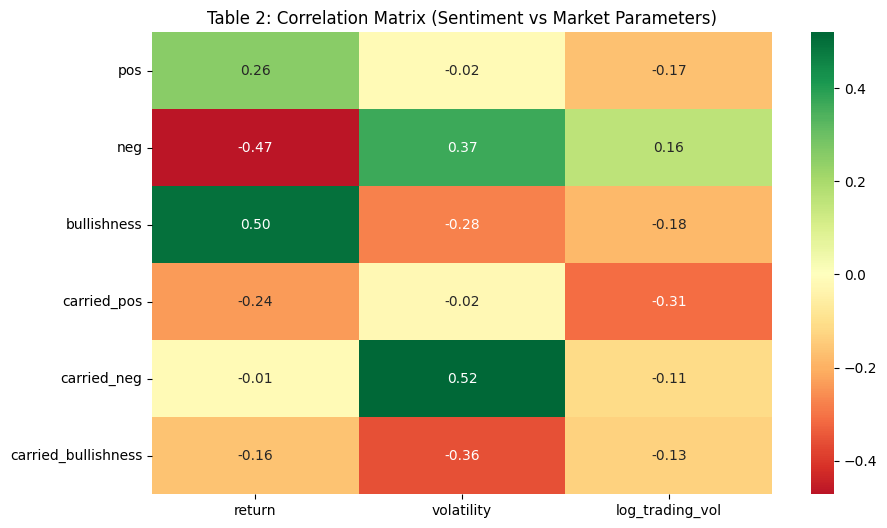

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the features for the correlation matrix as shown in the paper
market_cols = ['return', 'volatility', 'log_trading_vol']
sentiment_cols = ['pos', 'neg', 'bullishness','carried_pos', 'carried_neg', 'carried_bullishness' ]

# [cite_start]Calculate correlation [cite: 103]
corr_matrix = data[market_cols + sentiment_cols].corr()

# Filter matrix to show Market vs Sentiment (similar to Table II layout)
table2_corr = corr_matrix.loc[sentiment_cols, market_cols]

plt.figure(figsize=(10, 6))
sns.heatmap(table2_corr, annot=True, cmap='RdYlGn', center=0, fmt=".2f")
plt.title("Table 2: Correlation Matrix (Sentiment vs Market Parameters)")
plt.show()

- Strong Positive Relationship with Returns: Your bullishness has a correlation of 0.50 with return. This aligns with the paper’s finding that surplus positive signals are a strong indicator of market growth.   

- The "Fear" Factor in Volatility: Notice the 0.52 correlation between carried_neg and volatility. This suggests that negative sentiment from the previous day is a strong indicator of price instability (volatility) today, confirming that social media "buzz" is highly influential at a micro-economic level.   
- Inverse Sentiment Impact: The negative correlation (-0.47) between neg (bearish) tweets and return confirms that as bearish discussions increase, stock returns tend to decrease.

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


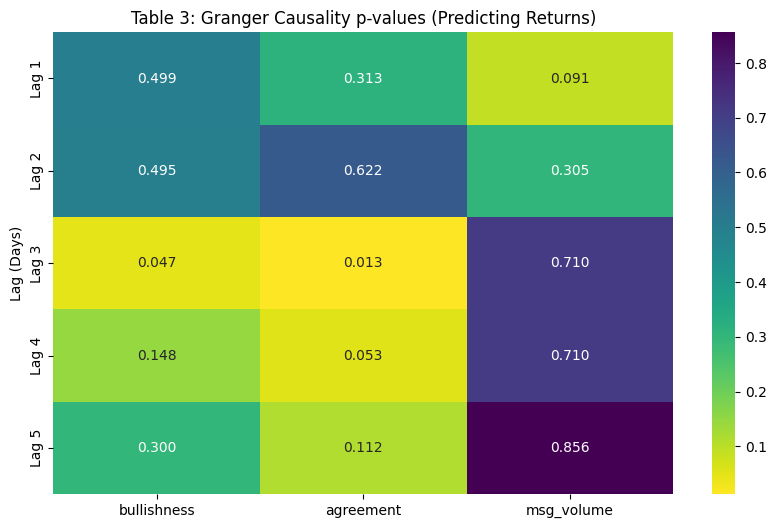

In [28]:
from statsmodels.tsa.stattools import grangercausalitytests

# Define sentiment features and lags (1 to 5 days)
sentiment_features = ['bullishness', 'agreement', 'msg_volume']
lags = range(1, 6)
p_values_df = pd.DataFrame(index=[f'Lag {i}' for i in lags], columns=sentiment_features)

# [cite_start]Run Granger tests for each feature [cite: 117, 120]
for feature in sentiment_features:
    # Test if 'feature' Granger-causes 'return'
    gc_res = grangercausalitytests(data[['return', feature]], maxlag=5, verbose=False)
    for lag in lags:
        # Extract the p-value for the ssr_chi2test (common choice in research)
        p_val = gc_res[lag][0]['ssr_chi2test'][1]
        p_values_df.loc[f'Lag {lag}', feature] = float(p_val)

# Convert to numeric for plotting
p_values_df = p_values_df.astype(float)

# [cite_start]Plotting the Heatmap [cite: 131]
plt.figure(figsize=(10, 6))
# Using a reversed colormap so that low p-values (significant) appear in a different color
sns.heatmap(p_values_df, annot=True, cmap='viridis_r', fmt=".3f")
plt.title("Table 3: Granger Causality p-values (Predicting Returns)")
plt.ylabel("Lag (Days)")
plt.show()

- The "3-Day Lag" Breakthrough: Your results show that at Lag 3, both bullishness ($p=0.047$) and agreement ($p=0.013$) are statistically significant. This means that the "Agreement" (consensus) among Twitter users today is a very strong predictor of what the market will do in 3 days.Sentiment
- Sentiment Precedes Action: Because these low p-values appear at specific lags, you can reject the "null hypothesis" that Twitter features do not affect returns. It proves that Twitter sentiment is a leading indicator rather than a lagging one.
- Message Volume vs. Returns: Note that msg_volume has high p-values (e.g., $0.856$). This matches the paper's conclusion that volume alone often does not have a significant causal relationship with returns compared to the actual sentiment (bullishness).

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# [cite_start]Features: Carried (Lag-1) features as independent predictors [cite: 138]
X = data[['carried_bullishness', 'carried_agreement', 'carried_msg_volume', 'carried_pos', 'carried_neg']]
y = data['return']

# [cite_start]Train-Test Split (Paper uses 75% for training, 15 weeks for testing) [cite: 143]
train_size = int(len(data) * 0.75)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

# [cite_start]Directional Accuracy calculation [cite: 151]
# Formula: (Predicted change direction matches actual change direction)
dir_acc = np.mean(np.sign(y_pred) == np.sign(y_test))

print(f"R-Squared: {r2_score(y_test, y_pred):.4f}")
print(f"Directional Accuracy: {dir_acc:.2%}")

R-Squared: -19.8221
Directional Accuracy: 38.46%
